In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [3]:
tf_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '../images',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4217 files belonging to 4 classes.


In [4]:
disease_names = tf_dataset.class_names

In [5]:
def partition_dataset(ds, train_split = 0.8, validation_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if(shuffle):
        ds = ds.shuffle(shuffle_size, seed = 5)

    train_size = int(train_split * ds_size)
    train_ds = ds.take(train_size)

    validation_size = int(validation_split * ds_size)
    validation_ds = ds.skip(train_size).take(validation_size)

    test_size = int(test_split * ds_size)
    test_ds = ds.skip(train_size).skip(validation_size)

    return train_ds, validation_ds, test_ds

In [6]:
train_ds, val_ds, test_ds = partition_dataset(tf_dataset)

In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [8]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [9]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.25),
    layers.RandomFlip("horizontal_and_vertical")
])

In [56]:
inputShape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
numberOfClasses = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = inputShape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(256, activation = 'relu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(numberOfClasses, activation = 'softmax')
])

model.build(input_shape = inputShape)

In [57]:
model.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_30 (Sequential)      │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_31 (Sequential)      │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_107         │ (32, 254, 254, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_103               │ (32, 127, 127, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_108         │ (32, 125, 125, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_104               │ (32, 62, 62, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (32, 60, 60, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_109         │ (32, 60, 60, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_105               │ (32, 30, 30, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (32, 28, 28, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_110         │ (32, 28, 28, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_106               │ (32, 14, 14, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (32, 12, 12, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_111         │ (32, 12, 12, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_107               │ (32, 6, 6, 256)        │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (32, 4, 4, 256)        │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_112         │ (32, 4, 4, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,393,988 (5.32 MB)

 Trainable params: 1,391,748 (5.31 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [58]:
model.compile(
    optimizer = optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [59]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [60]:
EPOCHS = 50
model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds,
    callbacks = [early_stopping, reduce_lr]
)

Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2698s 25s/step - accuracy: 0.4277 - loss: 5.2239 - val_accuracy: 0.3005 - val_loss: 4.4828 - learning_rate: 0.0010
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 530s 5s/step - accuracy: 0.5984 - loss: 3.1774 - val_accuracy: 0.3197 - val_loss: 4.4909 - learning_rate: 0.0010
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 555s 5s/step - accuracy: 0.6731 - loss: 2.0209 - val_accuracy: 0.3221 - val_loss: 3.2627 - learning_rate: 0.0010
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 479s 5s/step - accuracy: 0.7119 - loss: 1.4610 - val_accuracy: 0.4351 - val_loss: 2.3106 - learning_rate: 0.0010
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 447s 4s/step - accuracy: 0.7382 - loss: 1.1555 - val_accuracy: 0.6611 - val_loss: 1.1678 - learning_rate: 0.0010
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 440s 4s/step - accuracy: 0.7653 - loss: 0.9480 - val_accuracy: 0.7404 - val_loss: 0.9032 - learning_rate: 0.0010
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 496s 5s/step - accuracy: 0.7790 - loss: 

In [61]:
model.evaluate(test_ds)

14/14 ━━━━━━━━━━━━━━━━━━━━ 180s 775ms/step - accuracy: 0.8971 - loss: 0.2722


[0.29000166058540344, 0.8928571343421936]

In [17]:
model = tf.saved_model.load("../models/eye_classifier_1")

In [10]:
model_2 = tf.keras.models.load_model("../models/eye_classifier_1.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
cataract
normal
normal
glaucoma
glaucoma
diabetic_retinopathy
diabetic_retinopathy
diabetic_retinopathy
diabetic_retinopathy


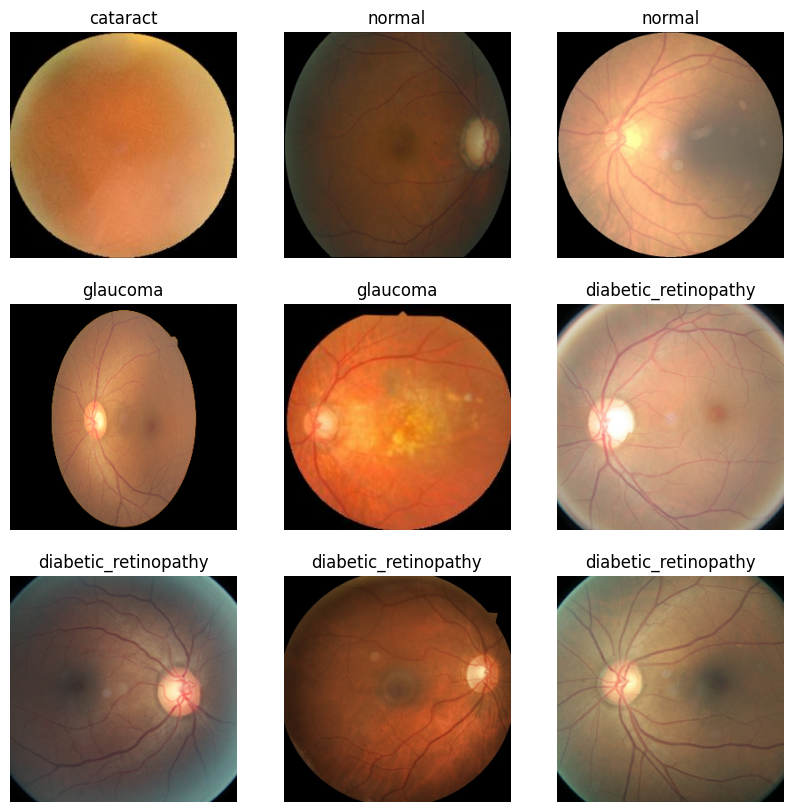

In [11]:
import numpy as np
plt.figure(figsize = (10,10))
for image_batch, label_batch in tf_dataset.take(1):
    batch_prediction = model_2.predict(image_batch)
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(disease_names[label_batch[i]])
        print(disease_names[np.argmax(batch_prediction[i])])
        plt.axis("off")

FIRST IMAGE : 
ACTUAL LABEL :  diabetic_retinopathy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
PREDICTION :  diabetic_retinopathy


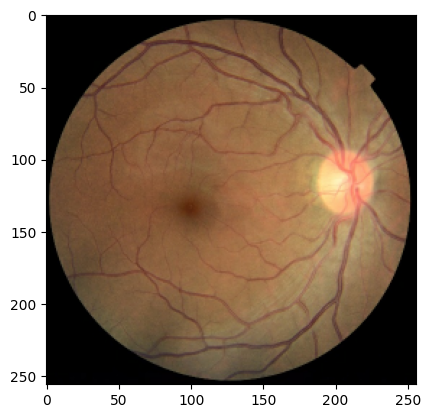

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("FIRST IMAGE : ")
    plt.imshow(first_image)
    print("ACTUAL LABEL : ", disease_names[first_label])

    batch_prediction = model_2.predict(images_batch)
    print("PREDICTION : ", disease_names[np.argmax(batch_prediction[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


'cataract'

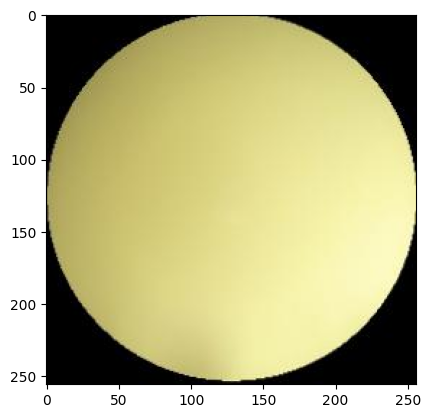

In [23]:
from PIL import Image
img = Image.open("../images/cataract/_100_334408.jpg")
img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
plt.imshow(img)
np_img = np.array(img)
fin_img = np.expand_dims(np_img, 0)
prediction = model_2.predict(fin_img)
disease_names[np.argmax(prediction[0])]

In [25]:
model_name = "eye_classifier_1"
model_2.save(f"../models/{model_name}.keras")

TypeError: cannot pickle 'module' object